In [16]:
import pandas as pd
import numpy as np
import nibabel as nib
import seaborn as sns 

import matplotlib.pyplot as plt
from neuromaps.images import relabel_gifti, load_data, load_gifti, annot_to_gifti
from neuromaps import parcellate
from neuromaps import transforms 
from neuromaps.stats import compare_images
from neuromaps.nulls import hungarian
from neuromaps.parcellate import Parcellater
from scipy.stats import pearsonr

from surfer import Brain
import os
from mayavi import mlab
from matplotlib.cm import get_cmap

mlab.init_notebook()

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Notebook initialized with ipy backend.


In [32]:
path = '/Users/laurituominen/Documents/Research/Reettis/neuromaps/'

# load enigma & turku partial correlation data 
enigma_data = pd.read_csv(path + 'data/ENIGMA_S32_partial_correlation_between_cortical_thickness_and_chlorpromazine_equivalents.csv')
enigma_data = enigma_data[:-2]
turku_data = pd.read_csv(path + 'data/turku_partial_r.csv')
turku_data = turku_data.rename(columns={"partial_r_sample": "partial_r"})


turku_data

,region_sample,partial_r
0,lh_bankssts,-0.141103
1,lh_caudalanteriorcingulate,0.006816
2,lh_caudalmiddlefrontal,-0.342748
3,lh_cuneus,-0.055788
4,lh_entorhinal,0.039894
...,...,...
63,rh_supramarginal,-0.284110
64,rh_frontalpole,-0.188452
65,rh_temporalpole,-0.141326
66,rh_transversetemporal,-0.172825


In [38]:
# Define file paths and read label data
lh_aparc_file = os.path.join(os.environ["SUBJECTS_DIR"], "fsaverage", "label", "lh.aparc.annot")
rh_aparc_file = os.path.join(os.environ["SUBJECTS_DIR"], "fsaverage", "label", "rh.aparc.annot")
lh_labels, lh_ctab, lh_names = nib.freesurfer.read_annot(lh_aparc_file)
rh_labels, rh_ctab, rh_names = nib.freesurfer.read_annot(rh_aparc_file)

# Modify label names and create dataframes
lh_names = ['lh_' + name.decode("utf-8") for name in lh_names if name.decode("utf-8") not in ['unknown', 'corpuscallosum']]
rh_names = ['rh_' + name.decode("utf-8") for name in rh_names if name.decode("utf-8") not in ['unknown', 'corpuscallosum']]

# 

def get_vertex_data(data, labels):
    vals = np.array(data['partial_r'])
    vtx = vals[labels]
    vtx[labels == -1] = -1
    vtx[np.where(np.isnan(vtx))] = 0
    return vtx

lh_enigma_vtx = get_vertex_data(enigma_data, lh_labels)
rh_enigma_vtx = get_vertex_data(enigma_data, rh_labels)

lh_turku_vtx = get_vertex_data(turku_data, lh_labels)
rh_turku_vtx = get_vertex_data(turku_data, rh_labels)

In [30]:
path = '/Users/laurituominen/Documents/Research/Reettis/neuromaps/'

# load enigma & turku partial correlation data 
enigma_data = pd.read_csv(path + 'data/ENIGMA_S32_partial_correlation_between_cortical_thickness_and_chlorpromazine_equivalents.csv')
enigma_data = enigma_data[:-2]
turku_data = pd.read_csv(path + 'data/turku_partial_r.csv')
turku_data = turku_data.rename(columns={"partial_r_sample": "partial_r"})

# Define file paths and read label data
lh_aparc_file = os.path.join(os.environ["SUBJECTS_DIR"], "fsaverage", "label", "lh.aparc.annot")
rh_aparc_file = os.path.join(os.environ["SUBJECTS_DIR"], "fsaverage", "label", "rh.aparc.annot")
lh_labels, lh_ctab, lh_names = nib.freesurfer.read_annot(lh_aparc_file)
rh_labels, rh_ctab, rh_names = nib.freesurfer.read_annot(rh_aparc_file)

# Modify label names and create dataframes
lh_names = ['left_' + name.decode("utf-8") for name in lh_names if name.decode("utf-8") not in ['unknown', 'corpuscallosum']]
rh_names = ['right_' + name.decode("utf-8") for name in rh_names if name.decode("utf-8") not in ['unknown', 'corpuscallosum']]
both_names = lh_names + rh_names
roi_df = pd.DataFrame({"roi_names": both_names})

# Merge dataframes and extract vertex and values data
#def prepare_data(roi_df, data, names):
#    data['roi_names'] = names
#    data = data[["roi_names", "partial_r"]]
#    df = roi_df.merge(data, on="roi_names", how="left")
#    return df

#enigma_df = prepare_data(roi_df, enigma_data, both_names)
#turku_df = prepare_data(roi_df, turku_data, both_names)

roi_df

,roi_names
0,left_bankssts
1,left_caudalanteriorcingulate
2,left_caudalmiddlefrontal
3,left_cuneus
4,left_entorhinal
...,...
63,right_supramarginal
64,right_frontalpole
65,right_temporalpole
66,right_transversetemporal


In [28]:
vals=np.array(enigma_data['partial_r'])
vtx = vals[lh_labels]
vtx[lh_labels == -1] = -1
vtx[np.where(np.isnan(vtx))] = 0

In [20]:


def get_vertex_data(df, data, labels):
    df = df.merge(data, on='roi_names', how='left')
    vals = np.array(df['partial_r'])
    vtx = vals[labels]
    vtx[labels == -1] = -1
    vtx[np.where(np.isnan(vtx))] = 0
    return vtx


lh_enigma_vtx = get_vertex_data(enigma_df, enigma_data, lh_labels)
rh_enigma_vtx = get_vertex_data(enigma_df, enigma_data, rh_labels)

lh_turku_vtx = get_vertex_data(turku_df, turku_data, lh_labels)
rh_turku_vtx = get_vertex_data(turku_df, turku_data, rh_labels)

KeyError: 'partial_r'

In [42]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

subject_id = "fsaverage"
surf = "inflated"

"""
Bring up the visualization.
"""
cmp_r = get_cmap('Blues_r')

brain = Brain(subject_id, 'lh', surf, views=['lat', 'med'],cortex = None, background="white")
brain.add_data(lh_enigma_vtx,-.4, 0, thresh=-0.4,colormap=cmp_r)
brain.add_annotation("aparc", color='black')
brain.save_image(path +'figures/left_enigma.jpg')
brain.close()

brain = Brain(subject_id, 'rh', surf, views=['lat', 'med'], cortex = None, background="white")
brain.add_data(rh_enigma_vtx,-.4, 0, thresh=-0.4,colormap=cmp_r)
brain.add_annotation("aparc", color='black')
brain.save_image(path + 'figures/right_enigma.jpg')
brain.close()

2023-10-12 15:06:01.095 (1968.719s) [           32DF2]       vtkThreshold.cxx:99    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2023-10-12 15:06:01.153 (1968.777s) [           32DF2]       vtkThreshold.cxx:99    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2023-10-12 15:06:01.271 (1968.895s) [           32DF2]       vtkThreshold.cxx:99    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2023-10-12 15:06:01.328 (1968.952s) [           32DF2]       vtkThreshold.cxx:99    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2023-10-12 15:06:02.764 (1970.388s) [           32DF2]       vtkThreshold.cxx:99    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2023-10-12 15:06:02.819 (1970.443s) [           32DF2] 

In [61]:

subject_id = "fsaverage"
surf = "inflated"

"""
Bring up the visualization.
"""
from matplotlib.cm import get_cmap
cmp_r = get_cmap('Blues_r')

brain = Brain(subject_id, 'lh', surf, views=['lat', 'med'], cortex = None, background="white")
brain.add_data(lh_turku_vtx,-.4, 0, thresh=-0.4,colormap=cmp_r)
brain.add_annotation("aparc", color='black')
brain.save_image(path + 'figures/left_turku.jpg')
brain.close()

brain = Brain(subject_id, 'rh', surf, views=['lat', 'med'], cortex = None,  background="white")
brain.add_data(rh_turku_vtx,-.4, 0, thresh=-0.4,colormap=cmp_r)
brain.add_annotation("aparc", color='black')
brain.save_image(path + 'figures/right_turku.jpg')
brain.close()

colormap sequential: [-4.00e-01, -2.00e-01, 0.00e+00] (opaque)
colormap sequential: [-4.00e-01, -2.00e-01, 0.00e+00] (opaque)


In [73]:
# do enigma map and turku map correlate?
turku_r = turku_df['partial_r'].to_numpy()
enigma_r = enigma_df['partial_r'].to_numpy()
rho, p = pearsonr(enigma_r, turku_r)

dk_fsaverage_164k = (path + 'parcellations/atlas-desikankilliany_space-fsaverage_den-164k_hemi-L.aparc-1.annot',
                     path + 'parcellations/atlas-desikankilliany_space-fsaverage_den-164k_hemi-R.aparc-1.annot')

dk_fsaverage_164k = annot_to_gifti(dk_fsaverage_164k)  # this does relabel_gift and also converts the annot file to gifti


# get spins 
spins = pd.read_csv(path + 'parcellations/spins_hungarian_aparc+aseg_ctx.csv', header=None)
nspins = spins.values.shape[1]

# get 10k rotations 
rotated = hungarian(data=turku_r, n_perm=10000, spins=spins, parcellation=dk_fsaverage_164k) 
    
# get null
n = np.zeros((nspins, ))
for i in range(nspins):
    n[i] = pearsonr(enigma_r, rotated[:,i])[0]    

# get p-value
pspin = (1 + sum(abs(n) > abs(rho ))) / (nspins + 1)

print(rho, pspin)

0.4741129502749724 0.0007999200079992001


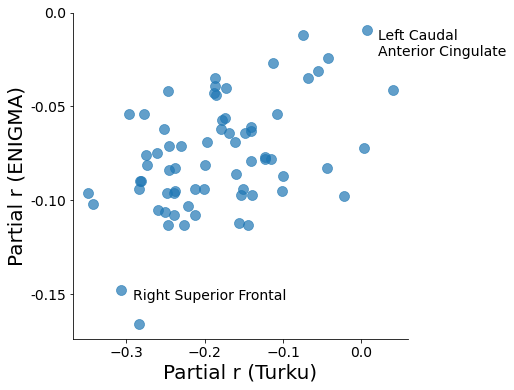

In [165]:

fig  = plt.figure(figsize=(6,6))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
#sns.regplot(x=turku_r, y= enigma_r, ci=None)

sns.scatterplot(turku_r, enigma_r, edgecolor=None, alpha=0.7, s=100)


fontdict = {'size':20}
plt.xlabel("Partial r (Turku)", fontdict=fontdict)
plt.ylabel("Partial r (ENIGMA)", fontdict=fontdict)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.yticks(ticks=[0, -0.05, -0.10,  -0.15 ], labels=["0.0",  "-0.05","-0.10",  "-0.15" ])
plt.text(turku_df['partial_r'][1] +0.015, enigma_df['partial_r'][1]-0.014, 'Left Caudal \nAnterior Cingulate', size=14)
plt.text(turku_df['partial_r'][60]+0.015, enigma_df['partial_r'][60]-0.005, 'Right Superior Frontal', size=14)

plt.savefig(path + 'figures/Correlation_TURKU_ENIGMA.jpg', dpi=300, bbox_inches="tight" )
plt.show()